# FEV vs. Alpha Analysis

For each VGG19 layer, this notebook plots **mean FEV** vs. **alpha** (where alpha is the slope of the log–log PCA variance spectrum).

- **Mean FEV** is taken from the regression: VGG19 features (reduced to N PCs) → PC1 Neural data

- For each layer, we select the **best FEV** (i.e., highest across PC counts)

In [1]:
from cortexlib.power_law import PowerLawAlphaEstimator
from cortexlib.utils import file as futils
from cortexlib.utils.logging import Logger
from cortexlib.utils.random import set_global_seed
from cortexlib.utils.plotting import vgg19_colours
from adjustText import adjust_text
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

logger = Logger()
set_global_seed()

In [2]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

17:34:18 | INFO     | ℹ️ This notebook is running for mouse m02_d3


In [3]:
fev_results = futils.read_json_file_as_dataframe('./prediction.json')
best_fev_per_layer = fev_results.loc[fev_results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
0,conv2_2,NaN,0.447306,0.487704
5,conv3_4,NaN,0.430649,0.469670
10,conv4_4,NaN,0.401695,0.438322
15,conv5_4,NaN,0.300184,0.328422
20,fc2,NaN,0.305729,0.334424


In [4]:
vgg19_data = futils.load_model_features(futils.Model.VGG19, MOUSE_ID)
vgg19_feats = vgg19_data['features']

17:34:18 | INFO     | ℹ️ Loading model features from /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m02_d3/_model_features/vgg19_features_mouse_m02_d3.pt


In [5]:
power_law_alpha_estimator = PowerLawAlphaEstimator()

alpha_results = []

logger.progress(f"Computing α for VGG19 features across layers")
for layer, feats in tqdm(vgg19_feats.items(), desc="α for all VGG19 layers"):
    logger.progress(f"VGG19 {layer}")

    feats = feats if feats.dim() <= 2 else feats.view(feats.size(0), -1)
    alpha = power_law_alpha_estimator.compute_alpha(feats)

    alpha_results.append({
        'layer': layer,
        'alpha': alpha['alpha'],
        'alpha_no_pc1': alpha['alpha_no_pc1'],
    })

logger.success(f"Alphas computed")

17:34:18 | INFO     | ⏳ Computing α for VGG19 features across layers...


α for all VGG19 layers:   0%|          | 0/5 [00:00<?, ?it/s]

17:34:18 | INFO     | ⏳ VGG19 conv2_2...
17:34:18 | INFO     | ⏳ VGG19 conv3_4...
17:34:19 | INFO     | ⏳ VGG19 conv4_4...


17:34:19 | INFO     | ⏳ VGG19 conv5_4...
17:34:19 | INFO     | ⏳ VGG19 fc2...


17:34:21 | SUCCESS  | ✅ Alphas computed!


In [6]:
futils.write_json_file(alpha_results, './dimensionality.json')

In [7]:
alpha_results_df = pd.DataFrame(alpha_results)
alpha_results_df

,layer,alpha,alpha_no_pc1
0,conv2_2,1.394331,1.418310
1,conv3_4,1.524415,1.541573
2,conv4_4,1.626546,1.663550
3,conv5_4,1.677220,1.709405
4,fc2,1.592539,1.602094


In [8]:
merged_results = pd.merge(best_fev_per_layer, alpha_results_df, on='layer')
merged_results

,layer,n_pcs,test_r2,mean_fev,alpha,alpha_no_pc1
0,conv2_2,NaN,0.447306,0.487704,1.394331,1.418310
1,conv3_4,NaN,0.430649,0.469670,1.524415,1.541573
2,conv4_4,NaN,0.401695,0.438322,1.626546,1.663550
3,conv5_4,NaN,0.300184,0.328422,1.677220,1.709405
4,fc2,NaN,0.305729,0.334424,1.592539,1.602094


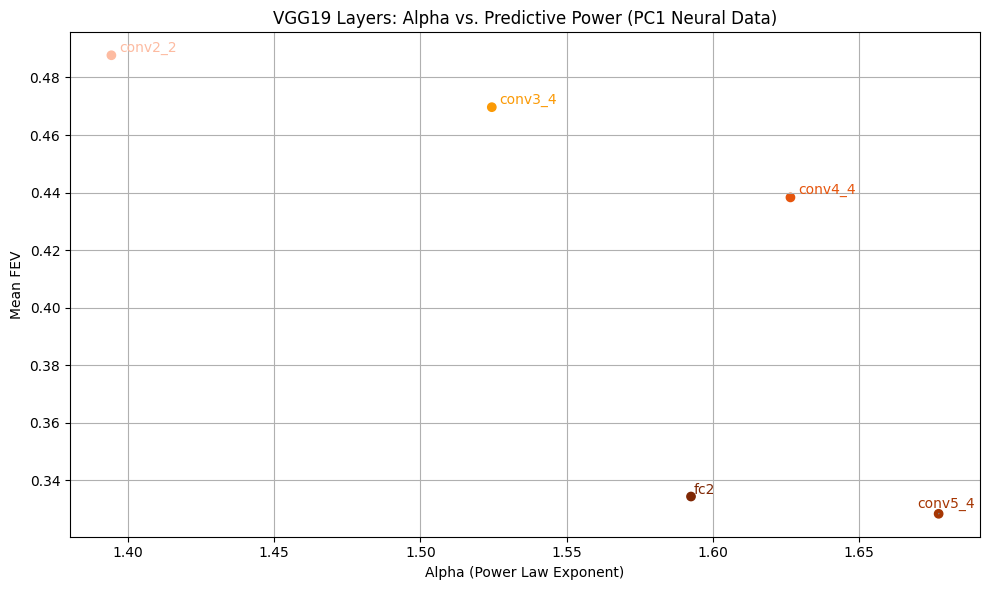

In [9]:
colours = merged_results['layer'].map(vgg19_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['alpha'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['alpha'], row['mean_fev'], row['layer'],
                 color=vgg19_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Alpha (Power Law Exponent)')
plt.ylabel('Mean FEV')
plt.title('VGG19 Layers: Alpha vs. Predictive Power (PC1 Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()